<a href="https://colab.research.google.com/github/hansikav/Decision-tree-and-random-forest/blob/main/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
!pip install sentencepiece


In [74]:
pip install transformers[sentencepiece]

In [75]:
!pip install transformers

In [76]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")

model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")


 

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:762: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [5]:
base_model = model.base_model


In [10]:
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
       
        return self.classifier(hidden_states[0][:, 0, :])

In [11]:
!mkdir -p tokenizer

In [12]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json')

In [13]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [14]:
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

In [15]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2021-05-05 15:06:00--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2021-05-05 15:06:01--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc50a6fc5f4599ff55dce9823c28.dl.dropboxusercontent.com/cd/0/inline/BN7Y4YxCcRy6FyoBo9JknBlhP-63erQz9LkkbZ2zheo_gTIbzcfBZ-4KjKYYY2_iU2nNW3Ruxh6o6znvaIQ6dNimUX3mlMyUsimnbnAwWoN7UVYZ5rUpgCHdRzp-qC5V7TcNzr9jydLSvL4G8_hmEpGi/file# [following]
--2021-05-05 15:06:01--  https://uc50a6fc5f4599ff55dce9823c28.dl.dropboxusercontent.com/cd/0/inline/BN7Y4YxCcRy6FyoBo9JknBlhP-63erQz9LkkbZ2zheo_gTIbzcfBZ-4KjKYYY2_iU2nNW

In [16]:
import pickle

## helper function
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

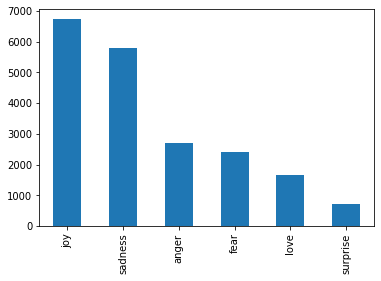

In [17]:
data = load_from_pickle(directory="merged_training.pkl")

## using a sample
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
data= data[data["emotions"].isin(emotions)]


data = data.sample(n=20000);

data.emotions.value_counts().plot.bar()

In [ ]:
data.head()

In [18]:
data.reset_index(drop=True, inplace=True)

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(), 
                                                                    data.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }




In [77]:
def get_emotion(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label


In [78]:
! pip install jsonlines

In [79]:
import jsonlines
import re
from nltk.stem.porter import PorterStemmer
use_stemmer = False
if use_stemmer:
        porter_stemmer = PorterStemmer()

def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word

def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' smile ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' laugh ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' love ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' wink ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' sad ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' cry ', tweet)
    return tweet


def preprocess(tweet):
  processed_tweet = []
  tweet = tweet.lower()
  tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet)
  tweet = re.sub(r'@[\S]+', '', tweet)
  tweet = tweet.split('url')[0]
  tweet = tweet.replace('url','')
  tweet = tweet.replace('qt','')
  tweet = re.sub(r'\brt\b', '', tweet)
  tweet = re.sub(r'\.{2,}', ' ', tweet)
  tweet = tweet.strip(' "\'')
  tweet = handle_emojis(tweet)
  tweet = re.sub(r'\s+', ' ', tweet)
  words = tweet.split()

  for word in words:
      word = preprocess_word(word)
      if True:
          if use_stemmer:
              word = str(porter_stemmer.stem(word))
          processed_tweet.append(word)

  return ' '.join(processed_tweet)

preprocessed_tweets = {}
sentiment_labels = {}
with jsonlines.open('output.jsonl', mode='w') as writer:
  with jsonlines.open('train_tweets.jsonl') as f:
    for line in f.iter():
        # Preprocess text
        text = preprocess(line['text'])
        emotion = get_emotion(text)
        line['text']= text
        line['emotion'] = emotion.replace('<pad> ','')
        writer.write(line)

In [ ]:
print(preprocess(" I'm more concerned with the side effects of the vaccine than I am with the symptoms of covid.\nI'm a healthy man."))

im more concerned with the side effects of the vaccine than i am with the symptoms of covid im a healthy man


In [80]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [81]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

In [82]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

In [84]:
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

In [85]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

In [86]:
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words)

In [87]:
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [88]:
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]

    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]

    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

In [89]:
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model

    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [90]:
import numpy
df = pd.read_csv('data1.csv', names=["id","text","misinfo", "stance"])

#df1 =  pd.read_json('output.jsonl',lines='true')
emotion=[]
id = []
text = []
with jsonlines.open('output.jsonl') as f:
    for line in f.iter():
        # Preprocess text
        text.append(line['text'])
        id.append(numpy.int64(line['id']))
        emotion.append(line['emotion'])

df1 = pd.DataFrame({'id':id,'tweet':text,'emotion':emotion})


In [91]:
df1["id"][384]

1339943721127669761

In [92]:
df1[df1['id']==1340015106206392321]

,id,tweet,emotion
91,1340015106206392321,so a bit like the virus then yet somehow we al...,joy


In [38]:
df['stance'].value_counts()

not_relevant    737
agree           646
disagree        371
no_stance       246
Name: stance, dtype: int64

In [39]:
df1['emotion'].value_counts()

fear        808
anger       415
joy         347
sadness      60
surprise      9
love          1
Name: emotion, dtype: int64

In [93]:
df3 = pd.merge(df,df1,on = 'id', how = 'left')


In [94]:
df3

,id,text,misinfo,stance,tweet,emotion
0,1340015106206392321,@meetnpatatas @RealMattCouch @Progressivemagi ...,More people will die as a result of a negative...,agree,so a bit like the virus then yet somehow we al...,joy
1,1340570906662322176,@armyveteran13 I said when the virus was first...,The COVID-19 vaccine causes infertility or mis...,agree,i said when the virus was first declared that ...,anger
2,1344724371865182208,Bombshell Interview With Del Bigtree: COVID Va...,The COVID-19 vaccine causes infertility or mis...,agree,bombshell interview with del bigtree covid vac...,anger
3,1345709249469546496,"YOLO- berichtgeving: ""COVID Vaccine Caused 4...",The COVID-19 vaccine causes Bell's palsy.,agree,yolo berichtgeving covid vaccine caused 4 peop...,anger
4,1344586458791723008,"@FatEmperor Natural immunity, I build up my bo...",Natural COVID-19 immunity is better than immun...,agree,natural immunity i build up my body for 19 yea...,anger
...,...,...,...,...,...,...
1995,1340059526641410048,If the coronavirus vaccine doesn't cause autis...,The COVID-19 vaccine causes infertility or mis...,not_relevant,if the coronavirus vaccine doesnt cause autism...,fear
1996,1340059526641410048,If the coronavirus vaccine doesn't cause autis...,The COVID-19 vaccine causes Bell's palsy.,not_relevant,if the coronavirus vaccine doesnt cause autism...,fear
1997,1340342873867186177,I'm more concerned with the side effects of th...,There are severe side effects of the COVID-19 ...,agree,im more concerned with the side effects of the...,fear
1998,1340342873867186177,I'm more concerned with the side effects of th...,More people will die as a result of a negative...,agree,im more concerned with the side effects of the...,fear


In [95]:

df3['tweet'].value_counts()

i am not going to take the covid19 vaccine                                                                                                                                                                                                      8
the covid19 vaccine could kill you with a allergic reaction 👀                                                                                                                                                                                   7
the covid19 vaccine is fake                                                                                                                                                                                                                     7
                                                                                                                                                                                                                                                6
will the covid19 vaccine cause i

In [96]:
df3["comb"] = df3["tweet"] + " " + df3["emotion"] + " " + df3["misinfo"] 
df3 = df3.reindex(np.random.permutation(df3.index))  
df3 = df3[['comb', 'stance']]
df3.text = df3.comb.apply(remove_stopwords).apply(remove_mentions)
df3.head(10)
df3.to_csv('df3.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [97]:
X_train, X_test, y_train, y_test = train_test_split(df3.comb, df3.stance, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 1800
# Test data samples: 200


In [98]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 1800 documents
10000 words in dictionary
Top 5 most common words are: [('the', 4509), ('vaccine', 3335), ('covid', 3091), ('19', 2183), ('a', 1654)]


In [99]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

In [100]:
label_to_index = {
    'not_relevant': 0, 
    'no_stance': 1, 
    'disagree': 2,
    'agree': 3
}

y_train_oh = y_train.apply(
    lambda x: label_to_index[x])
    
y_train_oh = np.asarray(y_train_oh) \
            .astype('float32')

y_test_oh = y_test.apply(
    lambda x: label_to_index[x])

y_test_oh = np.asarray(y_test_oh) \
            .astype('float32')

In [101]:
y_train_oh[:5]

array([3., 3., 2., 3., 2.], dtype=float32)

In [102]:

y_train

1890           agree
244            agree
1189        disagree
937            agree
348         disagree
            ...     
189         disagree
1742           agree
1561        disagree
1343    not_relevant
1122           agree
Name: stance, Length: 1800, dtype: object

In [103]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"0" is converted into [1. 0. 0. 0.]


In [104]:
y_train_le

array([0, 0, 1, ..., 1, 3, 0])

In [105]:
y_train_oh[:5]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [106]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (180, 10000)


In [107]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(128, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(32, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(512, activation='relu'))
drop_model.add(layers.Dense(4, activation='softmax'))
drop_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)              

In [108]:

drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)

Minimum validation loss reached in epoch 13


In [112]:
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

7/7 [==============================] - 0s 4ms/step - loss: 5.0009 - accuracy: 0.5200

Test accuracy: 52.00%


In [113]:
def get_target_text(m_id):
  m_id = int(m_id)
  if m_id == 1:
    return "RNA alters a person's DNA when taking the COVID-19 vaccine."
  if m_id == 2:
    return "The COVID-19 vaccine causes infertility or miscarriages in women."
  if m_id == 3:
    return "Natural COVID-19 immunity is better than immunity derived from a COVID-19 vaccine."
  if m_id == 4:
    return "The COVID-19 vaccine causes Bell's palsy."
  if m_id == 7:
    return "The COVID-19 vaccine contains tissue from aborted fetuses."
  if m_id == 8:
    return "The COVID-19 vaccine was developed to control the general population either through microchip tracking or nanotransducers in our brains."
  if m_id == 9:
    return "More people will die as a result of a negative side effect to the COVID-19 vaccine than would actually die from the coronavirus."
  if m_id == 10:
    return "There are severe side effects of the COVID-19 vaccines, worse than having the virus."

In [114]:
def predict_stance(tweet):
  stance_vector = drop_model.predict(tweet)[0]
  stance = np.argmax(stance_vector)
  if stance == 0:
    stance_label = 'agree'
  elif stance == 1:
    stance_label = 'disagree'
  elif stance == 2:
    stance_label = 'no_stance'
  else:
    stance_label = 'not_relevant'
  
  return stance_vector, stance_label

In [115]:
def predict_emotion_stance(tweet, m_id):
  target = get_target_text(m_id)
  emotion = get_emotion(preprocess(tweet))
  input = tweet + " " + emotion + " " + target
  input = remove_mentions(input)
  input = remove_stopwords(input)
  input = tk.texts_to_matrix([input], mode='binary')
  stance_vector, stance_label = predict_stance(input)

  return target, emotion, stance_label, stance_vector
  #print("Tweet:",tweet, "\nM_target:", target, "\nSentiment:", sentiment,"\n",sentiment_scores, "\nStance:", stance_label, "\n",stance_vector)

In [116]:
tweet = "My mom desen't want me to continue my education because we have to get a covid vaccine and she says it's a \"fact\" that it causes infertility."
target, emotion,stance_label, stance_vector = predict_emotion_stance(tweet, 2)
print("Tweet:",tweet, "\nM_target:", target, "\nEmotion:", emotion.replace('<pad>',''),
 "\nStance:", stance_label, "\n",stance_vector)

Tweet: My mom desen't want me to continue my education because we have to get a covid vaccine and she says it's a "fact" that it causes infertility. 
M_target: The COVID-19 vaccine causes infertility or miscarriages in women. 
Emotion:  anger 
Stance: agree 
 [9.9877781e-01 2.2095155e-05 1.9871324e-08 1.2000395e-03]
